# Web scraping data from Red Hook Star Revue

In this notebook I used Beautiful Soup to scrape data from the homepage and archives of the Red Hook Star Revue, a local newspaper in Red Hook. At the bottom of the homepage (http://www.star-revue.com/), there are two lists of popular stories: the most viewed and the most commented. This script scrapes information about each of these stories, including the title, number of views and comments, and category tags associated with that story. (Category tags are at the top of each article and are similar to hashtags - they are short phrases that relate to the content of the article.)

This script also scrapes data from the archives (http://www.star-revue.com/archives/), which takes much longer to process since it is pulling data about every story going back to 2013. But the focus is to get the number of comments and the category tags for every story as a way to measure interest and common issues over time. 

The archival data could be updated periodically. As for the most viewed and most commented stories on the homepage, it's unclear how often those are updated but that script could be executed much more often.

In [1]:
# Import libraries
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
import pandas as pd
from collections import defaultdict
import matplotlib.pylab as plt
from matplotlib.pyplot import cm
import itertools
import numpy as np

### Note:

The Red Hook Star Revue has bot protection set up, so scraping the data with Beautiful Soup is a little more complicated than usual. But if you enter your user agent in the header it should work. Go to this site to lookup your user agent:

https://www.whatismybrowser.com/detect/what-is-my-user-agent

Then enter it below.

In [2]:
# Setup
user_agent = 'Chrome/74.0.3729.169'

In [3]:
# Function for scraping data
def home_soup_maker():
    # Request
    home_url = 'http://www.star-revue.com/#sthash.l7beF1NS.dpbs'
    req = Request(home_url, headers={'User-Agent': user_agent})
    webpage = urlopen(req).read()
    soup = BeautifulSoup(webpage, "html.parser")
    return soup

In [4]:
# Scrape all the data
def home_scrape():
    soup = home_soup_maker()

    pop_dict = {}
    comm_dict = {}
    
    # Go through popular stories
    pop_soup = soup.findAll('div', attrs={'class':'widget popular-views'})[0].findAll('li')
    for story in pop_soup:
        story_dict = {'views':None,'comments':None}
        story_dict['type'] = 'popular'
        story_url = story.find('a').get('href')
        story_dict['url'] = story_url
        story_dict.update({'views':story.find('span').text.split()[0].strip()})
        
        # Get extra data from each story
        req = Request(story_url, headers={'User-Agent': user_agent})
        webpage = urlopen(req).read()
        story_soup = BeautifulSoup(webpage, "html.parser")
        
        # Get the categories listed at the top of each story
        cats = []
        cats_data = story_soup.findAll('a', attrs={'rel':'category tag'})
        for cat in cats_data:
            cats.append(cat.text)
        story_dict['cats'] = cats
        pop_dict[story.find('a').text] = story_dict

    # Make a df
    pop_df = pd.DataFrame.from_dict(pop_dict, orient='index').reset_index().rename(columns={'index':'title'})
    
    # Go through commented stories
    comm_soup = soup.findAll('div', attrs={'class':'widget popular-news'})[0].findAll('li')
    for story in comm_soup:
        story_dict = {'views':None,'comments':None}
        story_dict['type'] = 'commented'
        story_url = story.find('a').get('href')
        story_dict['url'] = story_url
        story_dict.update({'comments':story.find('span').text.split()[0].strip()})
        
        # Get extra data from each story
        req = Request(story_url, headers={'User-Agent': user_agent})
        webpage = urlopen(req).read()
        story_soup = BeautifulSoup(webpage, "html.parser")
        
        # Get the categories listed at the top of each story
        cats = []
        cats_data = story_soup.findAll('a', attrs={'rel':'category tag'})
        for cat in cats_data:
            cats.append(cat.text)
        story_dict['cats'] = cats
        comm_dict[story.find('a').text] = story_dict
    
    # Make a df
    comm_df = pd.DataFrame.from_dict(comm_dict, orient='index').reset_index().rename(columns={'index':'title'})
    
    # Combine the two
    final_df = pd.concat([pop_df, comm_df]).reset_index(drop=True)
    
    return final_df

In [5]:
# # Uncomment to rerun
# home_df = home_scrape()
# home_df

In [6]:
# # Export the data from 5/29/19
# home_df.to_csv('data/created_data/rh_star_revue_home.csv', index=False)

In [7]:
# Load data from previous export
home = pd.read_csv('data/created_data/rh_star_revue_home.csv')
home.head()

,title,views,comments,type,url,cats
0,Car hits mother and daughter at dangerous Red ...,4185.0,NaN,popular,http://www.star-revue.com/car-hits-mother-daug...,['Transportation']
1,Cobble Hill to change forever as LICH becomes ...,6361.0,NaN,popular,http://www.star-revue.com/cobble-hill-to-chang...,"['Brooklyn Bridge Park', 'Cobble Hill', 'LICH']"
2,"Red Hook gets its very own record store, by Ha...",2722.0,NaN,popular,http://www.star-revue.com/red-hook-gets-its-ve...,['Feature Story']
3,"Remembering George, by George Fiala",4710.0,NaN,popular,http://www.star-revue.com/remembering-george-g...,['Obituary']
4,"Tony Sterling’s alleged killers in custody, by...",4202.0,NaN,popular,http://www.star-revue.com/tony-sterlings-alleg...,"['Police', 'Red Hook Houses']"


## Scraping data from the archives

Very similar to what I did above but a lot more stories.

In [8]:
# Function for scraping data
def arch_soup_maker():
    # Request
    arch_url = 'http://www.star-revue.com/archives/#sthash.7yeLxCVm.dpbs'
    req = Request(arch_url, headers={'User-Agent': user_agent})
    webpage = urlopen(req).read()
    soup = BeautifulSoup(webpage, "html.parser")
    return soup

In [9]:
# Scrape all the data
def arch_scrape():
    # Get the soup from the archives page
    soup = arch_soup_maker()
    # Find the field that contains all the data we're interested in
    data = soup.find('div', attrs={'class':'entry-content'})
    
    # Set up a dictionary and a variable to store the year values
    year_dict = {}
    year = 0
    
    # Iterate over the data
    for item in data:
        # Get the year for each section
        if item.name=='h3':
            year = item.text
        # Get all the stories in each year
        elif item.name=='ul':
            list_items = item.findAll('li')
            for list_item in list_items:
                # Create a dictionary for all the values for each story
                mini_dict = {}
                mini_dict['year'] = year
                mini_dict['date'] = list_item.find('span', attrs={'class':'date'}).text
                story_url = list_item.find('a').get('href')
                mini_dict['url'] = story_url
                if 'Comments Off' in list_item.find('span', attrs={'class':'comments'}).text:
                    mini_dict['comments'] = None
                else:
                    mini_dict['comments'] = list_item.find('span', attrs={'class':'comments'}).text.split()[0]

                # Get extra data from each story
                req = Request(story_url, headers={'User-Agent': user_agent})
                webpage = urlopen(req).read()
                story_soup = BeautifulSoup(webpage, "html.parser")

                # Get the categories listed at the top of each story
                cats = []
                cats_data = story_soup.findAll('a', attrs={'rel':'category tag'})
                for cat in cats_data:
                    cats.append(cat.text)
                mini_dict['cats'] = cats
        
                # Add the data to the master dictionary with the story name as the key
                year_dict[list_item.find('span', attrs={'class':'linked'}).text] = mini_dict
    
    # Create and return a dataframe
    year_df = pd.DataFrame.from_dict(year_dict, orient='index').reset_index().rename(columns={'index':'title'})
    return year_df

In [10]:
# # Uncomment to rerun
# arch_df = arch_scrape()
# arch_df.head()

In [11]:
# # Export the data from 5/29/19
# arch_df.to_csv('data/created_data/rh_star_revue_arch.csv', index=False)

In [12]:
# Load data from previous export
arch = pd.read_csv('data/created_data/rh_star_revue_arch.csv')
arch.head()

,title,year,date,url,comments,cats
0,$100 million missing from Red Hook IFPS fundin...,2016,Apr 5th,http://www.star-revue.com/100-million-missing-...,NaN,"['NY Rising', 'Sandy Related']"
1,10 Professional Tips for Designing and Organiz...,2019,May 6th,http://www.star-revue.com/10-professional-tips...,0.0,['Kids']
2,100th Birthday Celebration for a Great Smith S...,2014,Sep 17th,http://www.star-revue.com/100th-birthday-celeb...,3.0,['Feature Story']
3,12 Brooklyn students presented videos at the J...,2018,Jan 16th,http://www.star-revue.com/12-brooklyn-students...,NaN,['Red Hook Justice Center']
4,"76th Precinct talks crime, shooting films, and...",2018,Nov 16th,http://www.star-revue.com/76th-precinct-talks-...,1.0,"['76th Precinct', 'NYCHA']"


In [13]:
arch.shape

(867, 6)

## Category counts

Each story posted to the Red Hook Star Revue is given at least one category tag (although some are just given the tag "Uncategorized"). I have already scraped all the category tags for every story in the archives. In the following cells, I do some simple tallies of tags to get a sense of their trends over time.

### Total counts across all years

In [14]:
"""
There's probably a better way to do this but this is what I came up with for counting strings in the 
categories column of the archives data. That column looks like a list of strings but it's actually just
a bunch of strings, which made it harder to count.
"""
# Create a new list to store all the strings
all_cats = []
# Go through all the category strings
for item in arch.cats:
    # Split each one on commas
    new_items = item.split("',")
    # Then do some manual cleanup to get the actual individual strings
    for new_item in new_items:
        all_cats.append(new_item.replace("'","").replace("[","").replace("]","").strip())
print("Number of individual category tags: {}".format(len(all_cats)))

Number of individual category tags: 1427


In [15]:
# Create a dictrionary of counts
counts_dict = defaultdict(int)
for string in all_cats:
    counts_dict[string] += 1

In [16]:
# Display the counts
counts = pd.DataFrame.from_dict(counts_dict, orient='index').reset_index()\
    .rename(columns={'index':'category_tag',0:'count'}).sort_values(by='count', ascending=False)\
    .reset_index(drop=True)
counts

,category_tag,count
0,Arts,106
1,Feature Story,51
2,Uncategorized,50
3,Politics,49
4,Carlos Menchaca,46
5,Music,45
6,Red Hook Houses,40
7,Real Estate,39
8,Editorials,38
9,Gowanus Canal,37


In [17]:
# Drop a few tags that are not informative
to_drop = ['Feature Story','Uncategorized','Editorials','Op Ed','Column']
counts = counts[~counts['category_tag'].isin(to_drop)].reset_index(drop=True)

In [18]:
# Parameter to keep the top x tags
top = 10

In [19]:
# Taking the top x tags and their counts (except for "Uncategorized")
top10x = counts['category_tag'][:top]
top10y = counts['count'][:top]

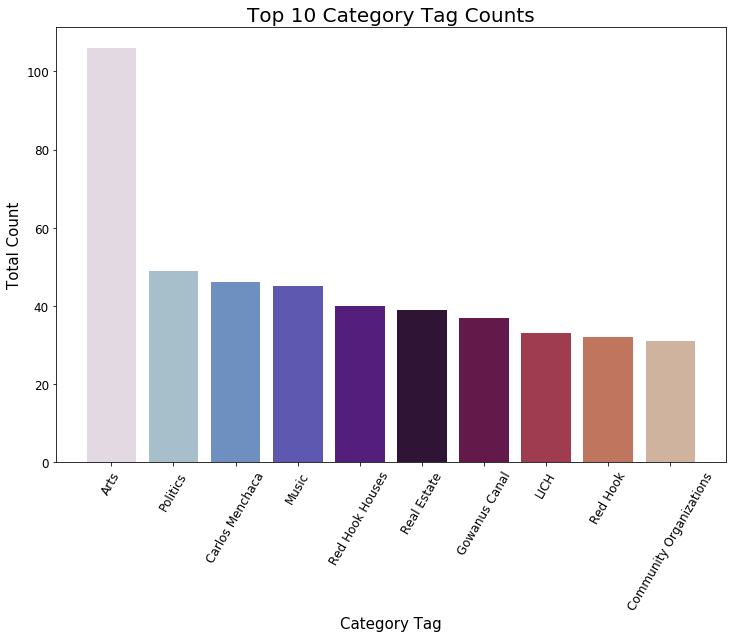

In [20]:
plt.figure(figsize=(12,8))
for i in range(0,len(top10x)):
    plt.bar(top10x[i],top10y[i],color=cm.twilight(1.*i/len(top10x)))

plt.title("Top {} Category Tag Counts".format(top), fontsize=20)
plt.xlabel("Category Tag", fontsize=15)
plt.ylabel("Total Count", fontsize=15)
plt.xticks(fontsize=12, rotation=60)
plt.yticks(fontsize=12)
plt.show()

### Counts for each year

In [21]:
# Group the data by year
arch_group = arch.groupby(['year'],as_index=False).agg(lambda x : x.sum() if x.dtype=='float64' else ' '.join(x))\
    .drop(['title','date','url'], axis=1)
arch_group

,year,comments,cats
0,2013,159.0,['Editorials'] ['LICH'] ['Sandy Related'] ['Ad...
1,2014,211.0,"['Feature Story'] ['Feature Story', 'Real Esta..."
2,2015,118.0,"['Brooklyn Bridge Park', 'Real Estate', 'Water..."
3,2016,77.0,"['NY Rising', 'Sandy Related'] ['Uncategorized..."
4,2017,92.0,"['Parks', 'Sports'] ['Op Ed', 'Politics'] ['Ar..."
5,2018,72.0,"['Red Hook Justice Center'] ['76th Precinct', ..."
6,2019,36.0,"['Kids'] ['Real Estate', 'Red Hook'] ['Arts', ..."


In [22]:
"""
Again, there's probably a better way to do this. But this is what I came up with for getting annual counts for
each category tag.
"""
cats13 = [2013]
cats14 = [2014]
cats15 = [2015]
cats16 = [2016]
cats17 = [2017] 
cats18 = [2018]
cats19 = [2019]

for i,r in arch.iterrows():
    # Split each one on commas
    new_cats = r.cats.split("',")
    # Then do some manual cleanup to get the actual individual strings
    for new_item in new_cats:
        final_item = new_item.replace("'","").replace("[","").replace("]","").strip()
        if r.year == 2013:
            cats13.append(final_item)
        elif r.year == 2014:
            cats14.append(final_item)
        elif r.year == 2015:
            cats15.append(final_item)
        elif r.year == 2016:
            cats16.append(final_item)
        elif r.year == 2017:
            cats17.append(final_item)
        elif r.year == 2018:
            cats18.append(final_item)
        else:
            cats19.append(final_item)

In [23]:
# Combine all the data for all the years
all_years = [cats13, cats14, cats15, cats16, cats17, cats18, cats19]

In [24]:
# Create a list that will store all the annual counts of strings
count_dfs = []
for year_cats in all_years:
    # Create a dictionary for each year
    master_dict = {}
    # Create a dictrionary of counts that will be come the values for each year
    counts_dict = defaultdict(int)
    # Iterate through all the strings in each year (not including the year value itself)
    for string in year_cats[1:]:
        # Add 1 every time you see the same string
        counts_dict[string] += 1
    # Finish creating the master dictionary using the year and all the counts
    master_dict[year_cats[0]] = counts_dict
    # Make a dataframe for each year
    counts = pd.DataFrame.from_dict(master_dict).reset_index()
    # Clean up the dataframe
    counts.rename(columns={'index':'string',counts.columns[1]:'count'}, inplace=True)
    counts['year'] = str(year_cats[0])
    counts = counts.sort_values(by='count', ascending=False).reset_index(drop=True)
    # Append it to the list of all annual counts
    count_dfs.append(counts)
    # Concat them all
    annual_counts = pd.concat(count_dfs).reset_index(drop=True)

In [25]:
# Preview the annual counts for each category tag
annual_counts

,string,count,year
0,LICH,22,2013
1,Uncategorized,15,2013
2,Feature Story,10,2013
3,Editorials,9,2013
4,Gowanus Canal,9,2013
5,Red Hook Houses,6,2013
6,Sandy Related,5,2013
7,Education,5,2013
8,Arts,4,2013
9,Politics,4,2013


In [26]:
annual_counts[annual_counts.string.isin(top10x)]

,string,count,year
0,LICH,22,2013
4,Gowanus Canal,9,2013
5,Red Hook Houses,6,2013
8,Arts,4,2013
9,Politics,4,2013
12,Real Estate,2,2013
18,Community Organizations,1,2013
20,Carlos Menchaca,1,2013
22,Politics,24,2014
23,Carlos Menchaca,20,2014


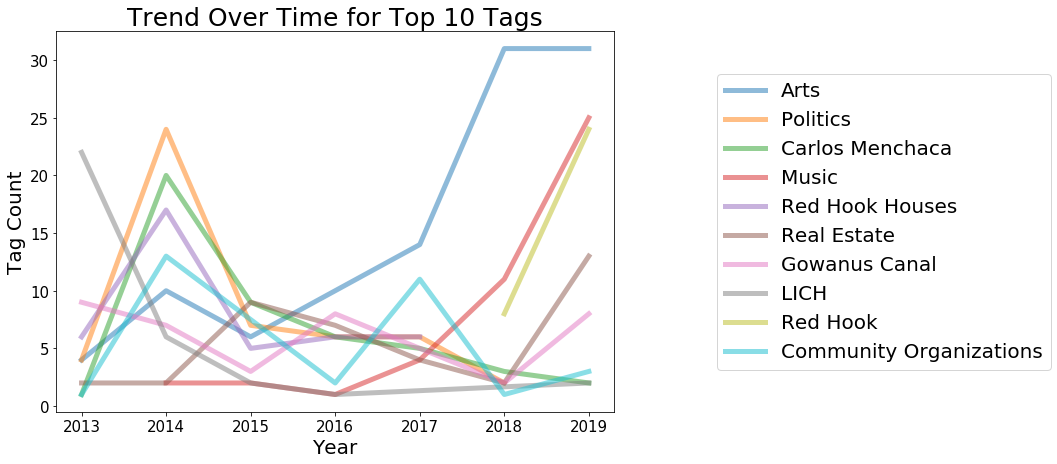

In [27]:
plt.figure(figsize=(10,7))
marker = itertools.cycle(('o', 'v', '+', 'P'))
for string in top10x:
    data = annual_counts[annual_counts['string']==string]
    plt.plot(data.interpolate(method='linear')['year'], \
             data.interpolate(method='linear')['count'], \
             label = string, markersize=12, linewidth=5, alpha=.5) #, marker = next(marker)
plt.title("Trend Over Time for Top {} Tags".format(top), fontsize=25)
plt.xlabel("Year", fontsize=20)
plt.ylabel("Tag Count", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(bbox_to_anchor=(1.8, .5), loc='right', fontsize=20)

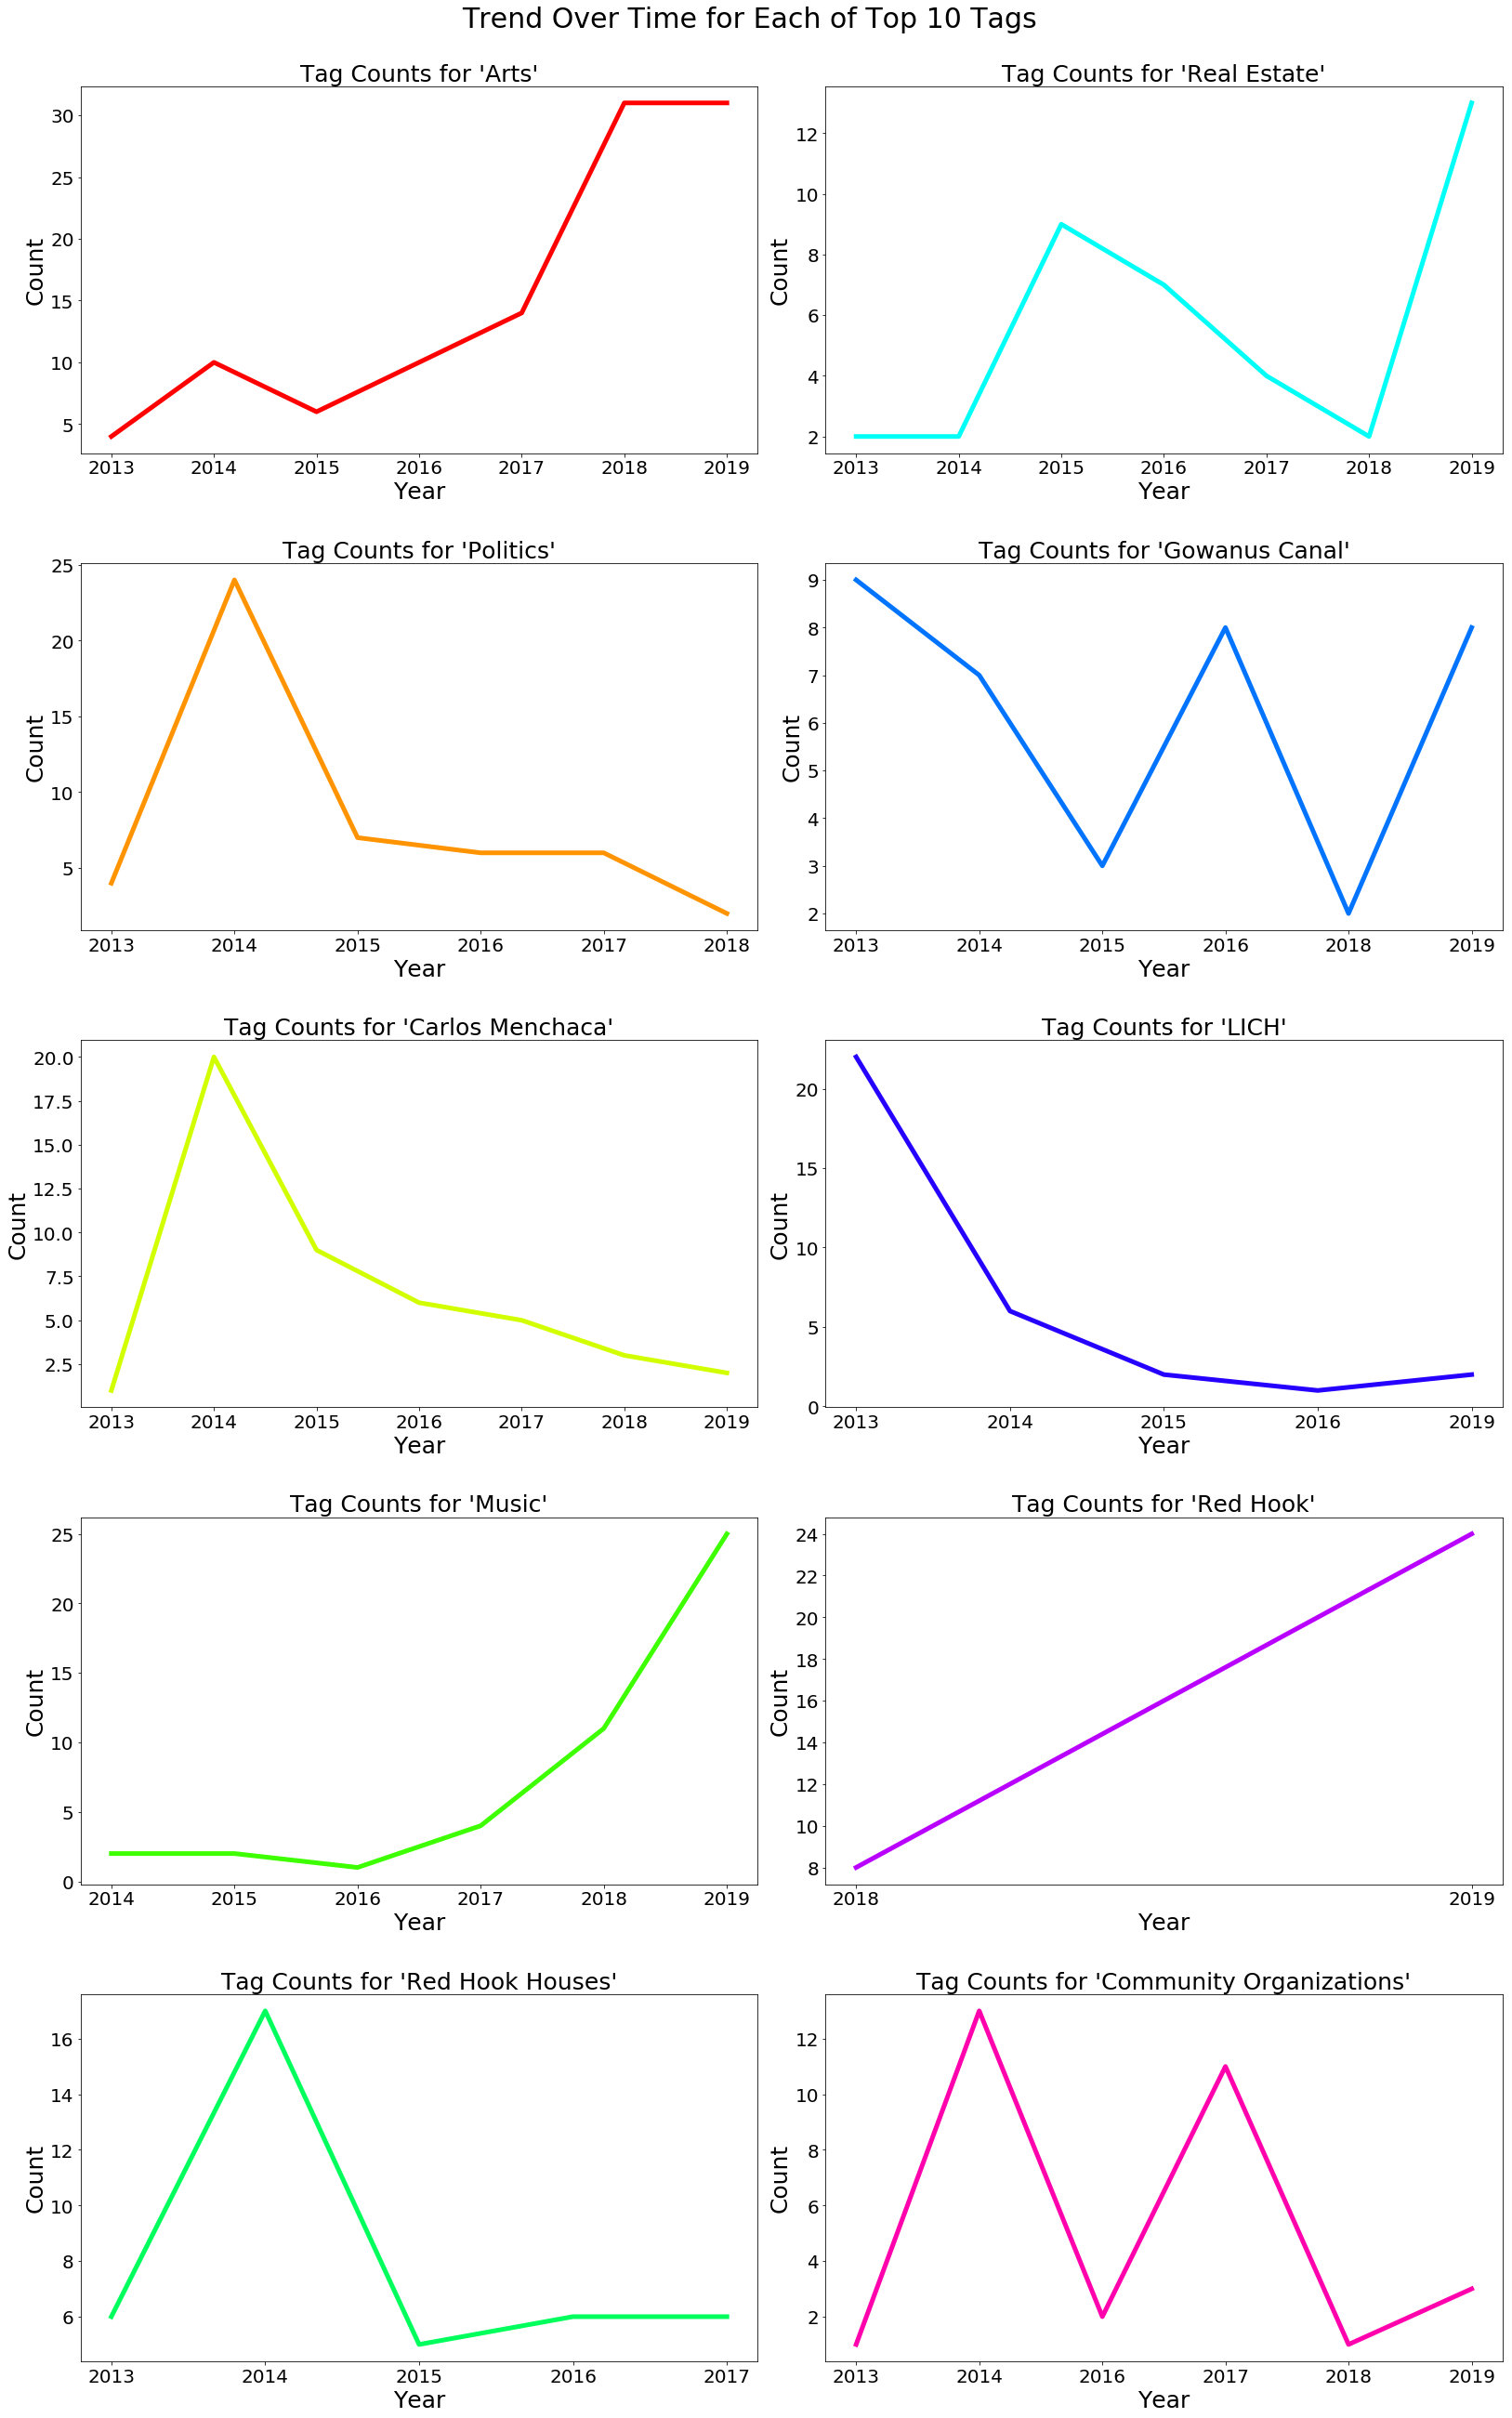

In [28]:
# To control font sizes
titles = 25
x_labels = 25
y_labels = 25
tick_size = 20

# Set up the plot
fig, axes = plt.subplots(5, 2, figsize=(25,40))
fig.suptitle("Trend Over Time for Each of Top {} Tags".format(top), fontsize=30)

# Plot
for i in range(len(top10x)):
    data = annual_counts[annual_counts['string']==top10x[i]]
    x = data['year']
    y = data['count']    
    if i <= 4:
        axes[i, 0].plot(x, y, color=cm.hsv(1.*i/len(top10x)), linewidth=5)
        axes[i, 0].set_title("Tag Counts for '{}'".format(top10x[i]), \
                                      fontdict={'fontsize':titles})
        axes[i, 0].set_xlabel("Year", fontdict={'fontsize':x_labels})
        axes[i, 0].set_ylabel("Count", fontdict={'fontsize':y_labels})
        axes[i, 0].tick_params(labelsize=tick_size)

    else:
        axes[i-5, 1].plot(x, y, color=cm.hsv(1.*i/len(top10x)), linewidth=5)
        axes[i-5, 1].set_title("Tag Counts for '{}'".format(top10x[i]), \
                              fontdict={'fontsize':titles})
        axes[i-5, 1].set_xlabel("Year", fontdict={'fontsize':x_labels})
        axes[i-5, 1].set_ylabel("Count", fontdict={'fontsize':y_labels})
        axes[i-5, 1].tick_params(labelsize=tick_size)
        
# Add padding
plt.subplots_adjust(top=.95, bottom=.1, left=0.10, right=0.95, hspace=0.3, wspace=0.1)